In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_excel('./data/train_clientes.xlsx', index_col='ID_CORRELATIVO')
df_test = pd.read_excel('./data/test_clientes.xlsx', index_col='ID_CORRELATIVO')

## Data Clientes

In [4]:
x_train = df_train.drop(['ATTRITION'], axis=1)
y_train = df_train['ATTRITION']
x_test = df_test

In [5]:
# Join train and test df to aplly feature engineering
df = pd.concat([x_train, x_test])
print df.shape

(100000, 51)


In [6]:
# Split columns by type
num_cols = df.select_dtypes(exclude=['datetime', 'object']).columns.tolist()
cat_cols = [col for col in df.columns if col not in num_cols]
cat_cols

[u'RANG_INGRESO',
 u'FLAG_LIMA_PROVINCIA',
 u'RANG_SDO_PASIVO_MENOS0',
 u'RANG_NRO_PRODUCTOS_MENOS0']

In [7]:
dm = pd.get_dummies(df[cat_cols[1]], prefix='FLAG')
df_ = pd.concat([df, dm], axis=1)
df_.drop(cat_cols[1], inplace=True, axis=1)
cat_cols.remove('FLAG_LIMA_PROVINCIA')

In [8]:
for col in cat_cols:
    df_[col] = df_[col].astype('category').cat.codes
    
df_.drop('CODMES', inplace=True, axis=1)
df_.head(5)

,FLG_BANCARIZADO,RANG_INGRESO,EDAD,ANTIGUEDAD,RANG_SDO_PASIVO_MENOS0,SDO_ACTIVO_MENOS0,SDO_ACTIVO_MENOS1,SDO_ACTIVO_MENOS2,SDO_ACTIVO_MENOS3,SDO_ACTIVO_MENOS4,...,NRO_ENTID_SSFF_MENOS4,NRO_ENTID_SSFF_MENOS5,FLG_SDO_OTSSFF_MENOS0,FLG_SDO_OTSSFF_MENOS1,FLG_SDO_OTSSFF_MENOS2,FLG_SDO_OTSSFF_MENOS3,FLG_SDO_OTSSFF_MENOS4,FLG_SDO_OTSSFF_MENOS5,FLAG_Lima,FLAG_Provincia
ID_CORRELATIVO,,,,,,,,,,,,,,,,,,,,,
35653,1,5,25.0,6.0,9,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,0
66575,1,2,27.0,0.0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
56800,1,0,34.0,4.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8410,1,3,63.0,5.0,3,0,0,0,0,0,...,3,3,1,1,1,1,1,1,0,1
6853,1,-1,25.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


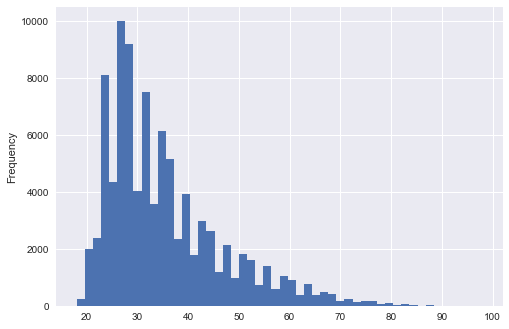

In [9]:
df_.EDAD.plot.hist(bins=50);

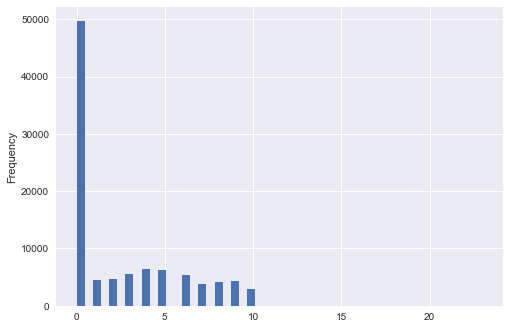

In [10]:
df_.ANTIGUEDAD.plot.hist(bins=50);

In [15]:
df_.EDAD.fillna(df_.EDAD.median(), inplace=True)

In [16]:
df_.ANTIGUEDAD.fillna(df_.ANTIGUEDAD.median(), inplace=True)

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


decomp = PCA(n_components=5)
pca_result = decomp.fit_transform(StandardScaler().fit_transform(df_.values))

In [33]:
cols = ['PCA{}'.format(i+1) for i in range(5)]

In [34]:
df_ = pd.DataFrame(data=pca_result, columns=cols)
df_.index=df.index

## Modelado clientes

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [36]:
x_train_ = df_.iloc[0:70000]
x_test_ = df_.iloc[70000:]

xtrain, xtest, ytrain, ytest = train_test_split(x_train_, y_train, test_size=.10, random_state=0)

### XGBoost

In [37]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)

params_xgb = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
}

xgb_model = xgb.train(params_xgb, 
                      dtrain,
                      num_boost_round=999, 
                      early_stopping_rounds=10,
                      evals=[(dtest, "Test")])

[0]	Test-logloss:0.564098
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.494121
[2]	Test-logloss:0.453393
[3]	Test-logloss:0.430364
[4]	Test-logloss:0.415571
[5]	Test-logloss:0.405807
[6]	Test-logloss:0.39985
[7]	Test-logloss:0.395994
[8]	Test-logloss:0.393946
[9]	Test-logloss:0.391933
[10]	Test-logloss:0.39093
[11]	Test-logloss:0.390661
[12]	Test-logloss:0.389872
[13]	Test-logloss:0.38853
[14]	Test-logloss:0.388401
[15]	Test-logloss:0.38763
[16]	Test-logloss:0.387251
[17]	Test-logloss:0.387262
[18]	Test-logloss:0.386171
[19]	Test-logloss:0.386741
[20]	Test-logloss:0.386794
[21]	Test-logloss:0.386041
[22]	Test-logloss:0.385927
[23]	Test-logloss:0.385251
[24]	Test-logloss:0.384924
[25]	Test-logloss:0.384882
[26]	Test-logloss:0.384805
[27]	Test-logloss:0.384888
[28]	Test-logloss:0.384565
[29]	Test-logloss:0.38463
[30]	Test-logloss:0.384306
[31]	Test-logloss:0.384389
[32]	Test-logloss:0.384602
[33]	Test-logloss:0.38438
[34]	Test-logloss:0.384611
[35]	Test-l

In [32]:
xgb.cv(params, 
       xgb.DMatrix(x_train_, label=y_train), 
       num_boost_round=999,
       early_stopping_rounds=10, 
       nfold=5, 
       seed=0,
       metrics='logloss')

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.540111,0.001392,0.539427,0.000601
1,0.456337,0.002398,0.455070,0.000817
2,0.406285,0.003232,0.404455,0.001024
3,0.373830,0.003567,0.371323,0.001222
4,0.353061,0.003998,0.349706,0.001395
5,0.339352,0.004470,0.335181,0.001314
6,0.330192,0.004983,0.324942,0.001378
7,0.323989,0.004919,0.317734,0.001637
8,0.319535,0.005360,0.312329,0.001381
9,0.316619,0.005523,0.308433,0.001269


In [33]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(9,12)
                    for min_child_weight in range(5,8)]

min_logloss = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params_xgb['max_depth'] = max_depth
    params_xgb['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=9, min_child_weight=5
	Logloss 0.3019878 for 19 rounds
CV with max_depth=9, min_child_weight=6
	Logloss 0.3019938 for 20 rounds
CV with max_depth=9, min_child_weight=7
	Logloss 0.3020584 for 17 rounds
CV with max_depth=10, min_child_weight=5
	Logloss 0.30276 for 17 rounds
CV with max_depth=10, min_child_weight=6
	Logloss 0.3018538 for 16 rounds
CV with max_depth=10, min_child_weight=7
	Logloss 0.3021882 for 18 rounds
CV with max_depth=11, min_child_weight=5
	Logloss 0.302065 for 15 rounds
CV with max_depth=11, min_child_weight=6
	Logloss 0.3016956 for 15 rounds
CV with max_depth=11, min_child_weight=7
	Logloss 0.3024108 for 14 rounds
Best params: 11, 6, Logloss: 0.3016956


In [111]:
params_xgb['max_depth'] = 11
params_xgb['min_child_weight'] = 6

In [35]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample, colsample)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with subsample=1.0, colsample=1.0
	Logloss 0.3016956 for 15 rounds
CV with subsample=1.0, colsample=0.9
	Logloss 0.301813 for 16 rounds
CV with subsample=1.0, colsample=0.8
	Logloss 0.301169 for 17 rounds
CV with subsample=1.0, colsample=0.7
	Logloss 0.3018682 for 16 rounds
CV with subsample=0.9, colsample=1.0
	Logloss 0.3025508 for 13 rounds
CV with subsample=0.9, colsample=0.9
	Logloss 0.3020234 for 15 rounds
CV with subsample=0.9, colsample=0.8
	Logloss 0.3027602 for 17 rounds
CV with subsample=0.9, colsample=0.7
	Logloss 0.302117 for 19 rounds
CV with subsample=0.8, colsample=1.0
	Logloss 0.303744 for 14 rounds
CV with subsample=0.8, colsample=0.9
	Logloss 0.3022242 for 14 rounds
CV with subsample=0.8, colsample=0.8
	Logloss 0.3029602 for 19 rounds
CV with subsample=0.8, colsample=0.7
	Logloss 0.303156 for 19 rounds
CV with subsample=0.7, colsample=1.0
	Logloss 0.3036902 for 14 rounds
CV with subsample=0.7, colsample=0.9
	Logloss 0.3032894 for 15 rounds
CV with subsample=0.7, co

In [112]:
params_xgb['subsample'] = 1.0
params_xgb['colsample_bytree'] = 0.8

In [37]:
min_logloss = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params_xgb['eta'] = eta
    
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta

print("Best params: {}, Logloss: {}".format(best_params, min_logloss))

CV with eta=0.3
	Logloss 0.301169 for 17 rounds
CV with eta=0.2
	Logloss 0.2999164 for 26 rounds
CV with eta=0.1
	Logloss 0.2982548 for 54 rounds
CV with eta=0.05
	Logloss 0.2977802 for 116 rounds
CV with eta=0.01
	Logloss 0.2973146 for 604 rounds
CV with eta=0.005
	Logloss 0.2978146 for 998 rounds
Best params: 0.01, Logloss: 0.2973146


In [113]:
params_xgb['eta'] = 0.01

In [114]:
params_xgb

{'colsample_bytree': 0.8,
 'eta': 0.01,
 'eval_metric': 'logloss',
 'max_depth': 11,
 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 1.0}

In [40]:
best_xgb_model = xgb.train(
    params_xgb,
    xgb.DMatrix(x_train_, label=y_train),
    num_boost_round=604
)

In [41]:
y_pred = best_xgb_model.predict(xgb.DMatrix(x_test_))
submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test_.index
submission['ATTRITION'] = y_pred
submission.head()

submission.to_csv('./data/submission14_XGB.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.374053
1,39861,0.278564
2,38898,0.023526
3,50927,0.014539
4,32969,0.363567


### LightGBM

In [42]:
# Lightgbm

dtrain =lgb.Dataset(xtrain,label=ytrain)
dtest = lgb.Dataset(xtest,label=ytest)

params_lgb = {'objective': 'binary',
          'max_depth': 6,
          'learning_rate':.3,
          'max_bin': 200,
          'metric': 'binary_logloss'}


lgb_model = lgb.train(params_lgb,
                      dtrain,
                      num_boost_round=999,
                      early_stopping_rounds=10,
                      valid_sets=[dtest, dtrain],
                      valid_names=["Test", "Train"]
                      )

[1]	Train's binary_logloss: 0.539359	Test's binary_logloss: 0.540194
Training until validation scores don't improve for 10 rounds.
[2]	Train's binary_logloss: 0.455084	Test's binary_logloss: 0.456778
[3]	Train's binary_logloss: 0.404938	Test's binary_logloss: 0.407416
[4]	Train's binary_logloss: 0.371791	Test's binary_logloss: 0.374792
[5]	Train's binary_logloss: 0.35137	Test's binary_logloss: 0.354528
[6]	Train's binary_logloss: 0.337076	Test's binary_logloss: 0.340333
[7]	Train's binary_logloss: 0.326848	Test's binary_logloss: 0.330454
[8]	Train's binary_logloss: 0.320195	Test's binary_logloss: 0.324332
[9]	Train's binary_logloss: 0.315489	Test's binary_logloss: 0.320418
[10]	Train's binary_logloss: 0.311734	Test's binary_logloss: 0.316944
[11]	Train's binary_logloss: 0.30874	Test's binary_logloss: 0.314812
[12]	Train's binary_logloss: 0.306662	Test's binary_logloss: 0.313082
[13]	Train's binary_logloss: 0.304714	Test's binary_logloss: 0.311823
[14]	Train's binary_logloss: 0.303184	T

In [43]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(9,12)
                    for min_child_weight in range(5,8)]

min_logloss = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params_lgb['max_depth'] = max_depth
    params_lgb['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = lgb.cv(
        params_lgb,
        lgb.Dataset(x_train_, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        metrics=['binary_logloss'],
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['binary_logloss-mean'])
    boost_rounds = len(cv_results['binary_logloss-mean'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=9, min_child_weight=5
	Logloss 0.302007861425 for 31 rounds
CV with max_depth=9, min_child_weight=6
	Logloss 0.302764372097 for 32 rounds
CV with max_depth=9, min_child_weight=7
	Logloss 0.302109801105 for 37 rounds
CV with max_depth=10, min_child_weight=5
	Logloss 0.302627212519 for 31 rounds
CV with max_depth=10, min_child_weight=6
	Logloss 0.30259731669 for 36 rounds
CV with max_depth=10, min_child_weight=7
	Logloss 0.302337873608 for 33 rounds
CV with max_depth=11, min_child_weight=5
	Logloss 0.301839794585 for 28 rounds
CV with max_depth=11, min_child_weight=6
	Logloss 0.301804794312 for 44 rounds
CV with max_depth=11, min_child_weight=7
	Logloss 0.301315875596 for 36 rounds
Best params: 11, 7, Logloss: 0.301315875596


In [116]:
params_lgb['max_depth'] = 11
params_lgb['min_child_weight'] = 7

In [45]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params_lgb['subsample'] = subsample
    params_lgb['colsample_bytree'] = colsample

    # Run CV
    cv_results = lgb.cv(
        params_lgb,
        lgb.Dataset(x_train_, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        metrics=['binary_logloss'],
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['binary_logloss-mean'])
    boost_rounds = len(cv_results['binary_logloss-mean'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample, colsample)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with subsample=1.0, colsample=1.0
	Logloss 0.301315875596 for 36 rounds
CV with subsample=1.0, colsample=0.9
	Logloss 0.301605787112 for 33 rounds
CV with subsample=1.0, colsample=0.8
	Logloss 0.301139242022 for 32 rounds
CV with subsample=1.0, colsample=0.7
	Logloss 0.301382287763 for 36 rounds
CV with subsample=0.9, colsample=1.0
	Logloss 0.301315875596 for 36 rounds
CV with subsample=0.9, colsample=0.9
	Logloss 0.301605787112 for 33 rounds
CV with subsample=0.9, colsample=0.8
	Logloss 0.301139242022 for 32 rounds
CV with subsample=0.9, colsample=0.7
	Logloss 0.301382287763 for 36 rounds
CV with subsample=0.8, colsample=1.0
	Logloss 0.301315875596 for 36 rounds
CV with subsample=0.8, colsample=0.9
	Logloss 0.301605787112 for 33 rounds
CV with subsample=0.8, colsample=0.8
	Logloss 0.301139242022 for 32 rounds
CV with subsample=0.8, colsample=0.7
	Logloss 0.301382287763 for 36 rounds
CV with subsample=0.7, colsample=1.0
	Logloss 0.301315875596 for 36 rounds
CV with subsample=0.7, co

In [117]:
params_lgb['subsample'] = 1.0
params_lgb['colsample_bytree'] = 0.8

In [109]:
min_logloss = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params_lgb['learning_rate'] = eta
    
    # Run CV
    cv_results = lgb.cv(
        params_lgb,
        lgb.Dataset(x_train_, label=y_train),
        num_boost_round=5000,
        seed=0,
        nfold=5,
        metrics=['binary_logloss'],
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['binary_logloss-mean'])
    boost_rounds = len(cv_results['binary_logloss-mean'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta

print("Best params: {}, Logloss: {}".format(best_params, min_logloss))

CV with eta=0.3
	Logloss 0.301139242022 for 32 rounds
CV with eta=0.2
	Logloss 0.300803432581 for 57 rounds
CV with eta=0.1
	Logloss 0.298725762419 for 157 rounds
CV with eta=0.05
	Logloss 0.299110335401 for 259 rounds
CV with eta=0.01
	Logloss 0.298868533403 for 1289 rounds
CV with eta=0.005
	Logloss 0.298945958294 for 2463 rounds
Best params: 0.1, Logloss: 0.298725762419


In [118]:
params_lgb['learning_rate'] = 0.1

In [126]:
best_lgb_model = lgb.train(params_lgb,
                      lgb.Dataset(x_train_, label=y_train),
                      num_boost_round=157
                      )

In [127]:
y_pred = best_lgb_model.predict(x_test_)

submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test_.index
submission['ATTRITION'] = y_pred
submission.head()

submission.to_csv('./data/submission14_LGB.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.319690
1,39861,0.211634
2,38898,0.028088
3,50927,0.013631
4,32969,0.282040


## Catboost

In [101]:
xtrain_ = xtrain.fillna(-999)
xtest_ = xtest.fillna(-999)

cat = CatBoostClassifier(iterations=120, 
                         learning_rate=0.3, 
                         depth=6, 
                         eval_metric='Logloss',
                         l2_leaf_reg=3,
                         border_count=32,
                         od_type='Iter')

cat.fit(xtrain_, ytrain, eval_set=(xtest_, ytest))

0:	learn: 0.4879995	test: 0.4870228	best: 0.4870228 (0)	total: 186ms	remaining: 22.1s
1:	learn: 0.3996157	test: 0.3987906	best: 0.3987906 (1)	total: 368ms	remaining: 21.7s
2:	learn: 0.3616182	test: 0.3604330	best: 0.3604330 (2)	total: 569ms	remaining: 22.2s
3:	learn: 0.3438614	test: 0.3422769	best: 0.3422769 (3)	total: 747ms	remaining: 21.7s
4:	learn: 0.3332636	test: 0.3318690	best: 0.3318690 (4)	total: 943ms	remaining: 21.7s
5:	learn: 0.3278904	test: 0.3266996	best: 0.3266996 (5)	total: 1.13s	remaining: 21.5s
6:	learn: 0.3234529	test: 0.3218799	best: 0.3218799 (6)	total: 1.34s	remaining: 21.7s
7:	learn: 0.3205778	test: 0.3201654	best: 0.3201654 (7)	total: 1.52s	remaining: 21.3s
8:	learn: 0.3173653	test: 0.3169261	best: 0.3169261 (8)	total: 1.73s	remaining: 21.3s
9:	learn: 0.3167142	test: 0.3165499	best: 0.3165499 (9)	total: 1.91s	remaining: 21s
10:	learn: 0.3155683	test: 0.3156029	best: 0.3156029 (10)	total: 2.14s	remaining: 21.2s
11:	learn: 0.3147207	test: 0.3150824	best: 0.3150824 (

94:	learn: 0.2811150	test: 0.2999763	best: 0.2993842 (88)	total: 18.9s	remaining: 4.98s
95:	learn: 0.2808835	test: 0.3000508	best: 0.2993842 (88)	total: 19.1s	remaining: 4.78s
96:	learn: 0.2805344	test: 0.3003778	best: 0.2993842 (88)	total: 19.3s	remaining: 4.58s
97:	learn: 0.2802377	test: 0.3003655	best: 0.2993842 (88)	total: 19.5s	remaining: 4.38s
98:	learn: 0.2800196	test: 0.3003154	best: 0.2993842 (88)	total: 19.7s	remaining: 4.19s
99:	learn: 0.2798289	test: 0.3003751	best: 0.2993842 (88)	total: 19.9s	remaining: 3.98s
100:	learn: 0.2796466	test: 0.3004894	best: 0.2993842 (88)	total: 20.1s	remaining: 3.79s
101:	learn: 0.2795575	test: 0.3004797	best: 0.2993842 (88)	total: 20.3s	remaining: 3.58s
102:	learn: 0.2793674	test: 0.3006760	best: 0.2993842 (88)	total: 20.5s	remaining: 3.38s
103:	learn: 0.2791936	test: 0.3007168	best: 0.2993842 (88)	total: 20.7s	remaining: 3.18s
104:	learn: 0.2789215	test: 0.3003583	best: 0.2993842 (88)	total: 20.9s	remaining: 2.98s
105:	learn: 0.2785636	test:

In [119]:
from catboost import cv, Pool

x_train__ = x_train_.fillna(-999)

params_cat = {
    'depth': 6,
    'learning_rate': .3,
    'iterations': 1000,
    'loss_function': 'Logloss',
    'l2_leaf_reg': 3,
    'border_count': 32,
    'od_type': 'Iter'
}

#cv(params, Pool(x_train__, y_train),  partition_random_seed=0, fold_count=5)

In [85]:
gridsearch_params = [depth for depth in range(4,12)]

min_logloss = float("Inf")
best_params = None

for depth in gridsearch_params:
    print("CV with depth={}".format(depth))

    # Update our parameters
    params_cat['depth'] = depth

    # Run CV
    cv_results = cv(
        params_cat,
        Pool(x_train__, y_train),  
        partition_random_seed=0, 
        fold_count=5
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['Logloss_test_avg'])
    boost_rounds = len(cv_results['Logloss_test_avg'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = depth
        best_rounds = boost_rounds

print("Best params: {}, Logloss: {}, Rounds: {}".format(best_params, min_logloss, best_rounds))

CV with depth=4
	Logloss 0.30423980111 for 147 rounds
CV with depth=5
	Logloss 0.302573060641 for 154 rounds
CV with depth=6
	Logloss 0.302653517225 for 115 rounds
CV with depth=7
	Logloss 0.301941417523 for 91 rounds
CV with depth=8
	Logloss 0.302723864531 for 96 rounds
CV with depth=9
	Logloss 0.302432334958 for 67 rounds
CV with depth=10
	Logloss 0.302566840871 for 60 rounds
CV with depth=11
	Logloss 0.302757829367 for 64 rounds
Best params: 7, Logloss: 0.301941417523, Rounds: 91


In [120]:
params_cat['depth'] = 7

In [128]:
params_cat

{'border_count': 32,
 'depth': 7,
 'iterations': 533,
 'l2_leaf_reg': 500,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'od_type': 'Iter'}

In [123]:
gridsearch_params = [10,100,200,500]

min_logloss = float("Inf")
best_params = None

for leaf_reg in gridsearch_params:
    print("CV with leaf_reg={}".format(leaf_reg))

    # Update our parameters
    params_cat['l2_leaf_reg'] = leaf_reg

    # Run CV
    cv_results = cv(
        params_cat,
        Pool(x_train__, y_train),  
        partition_random_seed=0, 
        fold_count=5
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['Logloss_test_avg'])
    boost_rounds = len(cv_results['Logloss_test_avg'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = leaf_reg
        best_rounds = boost_rounds

print("Best params: {}, Logloss: {}, Rounds: {}".format(best_params, min_logloss, best_rounds))

CV with leaf_reg=10
	Logloss 0.297993372921 for 405 rounds
CV with leaf_reg=100
	Logloss 0.296618841003 for 533 rounds
CV with leaf_reg=200
	Logloss 0.296863228118 for 533 rounds
CV with leaf_reg=500


KeyboardInterrupt: 

In [129]:
params_cat['l2_leaf_reg'] = 100

In [90]:
min_logloss = float("Inf")
best_params = None

params_cat['iterations'] = 5000

for eta in [0.05]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params_cat['learning_rate'] = eta

    # Run CV
    cv_results = cv(
        params_cat,
        Pool(x_train__, y_train),  
        partition_random_seed=0, 
        fold_count=5
    )

    # Update best logloss
    mean_logloss = np.min(cv_results['Logloss_test_avg'])
    boost_rounds = len(cv_results['Logloss_test_avg'])
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta
        best_rounds = boost_rounds

print("Best params: {}, Logloss: {}, Rounds: {}".format(best_params, min_logloss, best_rounds))

CV with eta=0.05
	Logloss 0.296545588394 for 1020 rounds
Best params: 0.05, Logloss: 0.296545588394, Rounds: 1020


In [131]:
params_cat['iterations'] = 533
params_cat['learning_rate'] = 0.1

In [132]:
cat = CatBoostClassifier(**params_cat)

cat.fit(x_train__, y_train)

0:	learn: 0.6099229	total: 221ms	remaining: 1m 57s
1:	learn: 0.5481480	total: 445ms	remaining: 1m 58s
2:	learn: 0.4995824	total: 696ms	remaining: 2m 2s
3:	learn: 0.4619350	total: 947ms	remaining: 2m 5s
4:	learn: 0.4402092	total: 1.19s	remaining: 2m 5s
5:	learn: 0.4168744	total: 1.46s	remaining: 2m 8s
6:	learn: 0.3996531	total: 1.69s	remaining: 2m 7s
7:	learn: 0.3855065	total: 1.94s	remaining: 2m 7s
8:	learn: 0.3745852	total: 2.18s	remaining: 2m 6s
9:	learn: 0.3639721	total: 2.42s	remaining: 2m 6s
10:	learn: 0.3575227	total: 2.68s	remaining: 2m 7s
11:	learn: 0.3522394	total: 2.92s	remaining: 2m 6s
12:	learn: 0.3489108	total: 3.16s	remaining: 2m 6s
13:	learn: 0.3451069	total: 3.4s	remaining: 2m 6s
14:	learn: 0.3408515	total: 3.66s	remaining: 2m 6s
15:	learn: 0.3383942	total: 3.92s	remaining: 2m 6s
16:	learn: 0.3357892	total: 4.17s	remaining: 2m 6s
17:	learn: 0.3336509	total: 4.43s	remaining: 2m 6s
18:	learn: 0.3311787	total: 4.74s	remaining: 2m 8s
19:	learn: 0.3293177	total: 4.98s	remain

159:	learn: 0.2924095	total: 39.2s	remaining: 1m 31s
160:	learn: 0.2923125	total: 39.4s	remaining: 1m 31s
161:	learn: 0.2922154	total: 39.6s	remaining: 1m 30s
162:	learn: 0.2921130	total: 39.9s	remaining: 1m 30s
163:	learn: 0.2920779	total: 40.1s	remaining: 1m 30s
164:	learn: 0.2920612	total: 40.4s	remaining: 1m 30s
165:	learn: 0.2920009	total: 40.6s	remaining: 1m 29s
166:	learn: 0.2919348	total: 40.8s	remaining: 1m 29s
167:	learn: 0.2919149	total: 41.1s	remaining: 1m 29s
168:	learn: 0.2918546	total: 41.3s	remaining: 1m 29s
169:	learn: 0.2916809	total: 41.6s	remaining: 1m 28s
170:	learn: 0.2916629	total: 41.8s	remaining: 1m 28s
171:	learn: 0.2916233	total: 42s	remaining: 1m 28s
172:	learn: 0.2916024	total: 42.3s	remaining: 1m 27s
173:	learn: 0.2915481	total: 42.5s	remaining: 1m 27s
174:	learn: 0.2914932	total: 42.8s	remaining: 1m 27s
175:	learn: 0.2913347	total: 43s	remaining: 1m 27s
176:	learn: 0.2911900	total: 43.2s	remaining: 1m 26s
177:	learn: 0.2911103	total: 43.5s	remaining: 1m 2

316:	learn: 0.2812741	total: 1m 16s	remaining: 52.2s
317:	learn: 0.2812404	total: 1m 16s	remaining: 51.9s
318:	learn: 0.2811746	total: 1m 17s	remaining: 51.7s
319:	learn: 0.2811584	total: 1m 17s	remaining: 51.4s
320:	learn: 0.2810840	total: 1m 17s	remaining: 51.2s
321:	learn: 0.2809341	total: 1m 17s	remaining: 50.9s
322:	learn: 0.2809024	total: 1m 17s	remaining: 50.7s
323:	learn: 0.2808517	total: 1m 18s	remaining: 50.4s
324:	learn: 0.2807612	total: 1m 18s	remaining: 50.2s
325:	learn: 0.2807143	total: 1m 18s	remaining: 50s
326:	learn: 0.2806006	total: 1m 18s	remaining: 49.7s
327:	learn: 0.2805619	total: 1m 19s	remaining: 49.5s
328:	learn: 0.2804991	total: 1m 19s	remaining: 49.2s
329:	learn: 0.2804079	total: 1m 19s	remaining: 49s
330:	learn: 0.2803788	total: 1m 19s	remaining: 48.8s
331:	learn: 0.2803352	total: 1m 20s	remaining: 48.5s
332:	learn: 0.2803033	total: 1m 20s	remaining: 48.3s
333:	learn: 0.2802144	total: 1m 20s	remaining: 48.1s
334:	learn: 0.2801893	total: 1m 20s	remaining: 47.

472:	learn: 0.2729631	total: 1m 54s	remaining: 14.5s
473:	learn: 0.2729234	total: 1m 54s	remaining: 14.3s
474:	learn: 0.2728889	total: 1m 55s	remaining: 14s
475:	learn: 0.2728495	total: 1m 55s	remaining: 13.8s
476:	learn: 0.2727749	total: 1m 55s	remaining: 13.6s
477:	learn: 0.2727496	total: 1m 55s	remaining: 13.3s
478:	learn: 0.2727095	total: 1m 56s	remaining: 13.1s
479:	learn: 0.2726900	total: 1m 56s	remaining: 12.8s
480:	learn: 0.2726505	total: 1m 56s	remaining: 12.6s
481:	learn: 0.2726201	total: 1m 56s	remaining: 12.4s
482:	learn: 0.2725686	total: 1m 57s	remaining: 12.1s
483:	learn: 0.2725375	total: 1m 57s	remaining: 11.9s
484:	learn: 0.2725018	total: 1m 57s	remaining: 11.6s
485:	learn: 0.2724447	total: 1m 57s	remaining: 11.4s
486:	learn: 0.2724039	total: 1m 58s	remaining: 11.1s
487:	learn: 0.2723599	total: 1m 58s	remaining: 10.9s
488:	learn: 0.2723226	total: 1m 58s	remaining: 10.7s
489:	learn: 0.2722352	total: 1m 58s	remaining: 10.4s
490:	learn: 0.2721589	total: 1m 59s	remaining: 1

In [133]:
cat.get_params()

{'border_count': 32,
 'depth': 7,
 'iterations': 533,
 'l2_leaf_reg': 100,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'od_type': 'Iter'}

In [134]:
x_test__ = x_test_.fillna(-999)

submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test__.index
submission['ATTRITION'] = cat.predict_proba(x_test__)[:,1]
submission.to_csv('./data/submission14_CAT.csv', index=False)

## Modelado requerimientos

In [217]:
x_req = df_train_req.join(y_train).drop('ATTRITION', axis=1)
y_req = df_train_req.join(y_train)['ATTRITION']
x_req.fillna(-999, inplace=True)

In [218]:
x_train_req, x_test_req, y_train_req, y_test_req = train_test_split(x_req, y_req, test_size=.10, random_state=1234)

In [219]:
cat_feat_index = np.where(x_req.dtypes != np.int64)[0]

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
cat.fit(x_train_req, y_train_req, cat_features=cat_feat_index, eval_set=(x_test_req, y_test_req))

0:	learn: 0.6044600	test: 0.6031466	best: 0.6031466 (0)	total: 113ms	remaining: 11.2s
1:	learn: 0.5360142	test: 0.5335257	best: 0.5335257 (1)	total: 154ms	remaining: 7.53s
2:	learn: 0.4833144	test: 0.4797636	best: 0.4797636 (2)	total: 211ms	remaining: 6.82s
3:	learn: 0.4425946	test: 0.4381694	best: 0.4381694 (3)	total: 287ms	remaining: 6.89s
4:	learn: 0.4113655	test: 0.4060800	best: 0.4060800 (4)	total: 328ms	remaining: 6.22s
5:	learn: 0.3870200	test: 0.3810510	best: 0.3810510 (5)	total: 455ms	remaining: 7.12s
6:	learn: 0.3683349	test: 0.3616980	best: 0.3616980 (6)	total: 545ms	remaining: 7.24s
7:	learn: 0.3538443	test: 0.3465183	best: 0.3465183 (7)	total: 621ms	remaining: 7.14s
8:	learn: 0.3425319	test: 0.3346711	best: 0.3346711 (8)	total: 746ms	remaining: 7.54s
9:	learn: 0.3337013	test: 0.3253680	best: 0.3253680 (9)	total: 811ms	remaining: 7.3s
10:	learn: 0.3265408	test: 0.3178328	best: 0.3178328 (10)	total: 898ms	remaining: 7.26s
11:	learn: 0.3211377	test: 0.3120240	best: 0.3120240 

95:	learn: 0.2972434	test: 0.2859774	best: 0.2859765 (94)	total: 8.42s	remaining: 351ms
96:	learn: 0.2971881	test: 0.2859623	best: 0.2859623 (96)	total: 8.54s	remaining: 264ms
97:	learn: 0.2971674	test: 0.2859644	best: 0.2859623 (96)	total: 8.66s	remaining: 177ms
98:	learn: 0.2971250	test: 0.2859578	best: 0.2859578 (98)	total: 8.8s	remaining: 88.8ms
99:	learn: 0.2970371	test: 0.2859411	best: 0.2859411 (99)	total: 8.99s	remaining: 0us

bestTest = 0.2859410566
bestIteration = 99



In [57]:
from catboost import cv, Pool

params ={
    'depth': 6,
    'learning_rate': .1,
    'iterations': 100,
    'loss_function': 'Logloss'
}

cv(params, Pool(x_train_req, y_train_req, cat_features=cat_feat_index),  partition_random_seed=1234, fold_count=5)

defaultdict(list,
            {'Logloss_test_avg': [0.6044590655482499,
              0.5358769341370746,
              0.4831631361206874,
              0.44266836665059667,
              0.41130337126945904,
              0.387199392487251,
              0.36854173334588264,
              0.35395704295215674,
              0.34267024847766736,
              0.33383455044077237,
              0.3268189790347938,
              0.32134512608824817,
              0.3170148265141174,
              0.31358654291561605,
              0.3108858404954843,
              0.3087493540895614,
              0.30703190890868537,
              0.3056071108638281,
              0.3044784752974292,
              0.30361880765614996,
              0.30287648987621496,
              0.30227719167405254,
              0.30180587338820675,
              0.30143048209180734,
              0.3011080926921161,
              0.30076702870558575,
              0.30057768507970434,
              0.3003539898528

In [305]:
df_test_req['ATTRITION_REQ'] = cat.predict_proba(df_test_req)[:, 1]

df_test_req_ = df_test_req.groupby(by=df_test_req.index)['ATTRITION_REQ'].mean()

new_submission = pd.DataFrame(index=x_test_.index)
new_submission['ATT'] = y_pred
new_submission.head()

,ATT
ID_CORRELATIVO,
47411,0.291465
39861,0.269891
38898,0.028191
50927,0.019253
32969,0.470753


In [306]:
df_test_req_ = new_submission.join(df_test_req_)
df_test_req_['ATTRITION'] = df_test_req_.apply(lambda x: np.mean(x), axis=1)

In [307]:
df_test_req_.reset_index(inplace=True)
df_test_req_[['ID_CORRELATIVO', 'ATTRITION']].to_csv('./data/submission11.csv', index=False)